## Fine Tuning the model

Modifications applied:

* retraining the model
* focal loss in comiling
* Unfreeze base layers of the model
* fine-tune model
* scheduling function
* tta for prediction

Best results obtained with: Epochs= 30, Batch-size= 32

In [1]:
# import libraries

import os
import random
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import tensorflow as tf

In [ ]:
# Paths

labels_csv_path = "/kaggle/input/code1a-results/Data/labels.csv"         # path of the csv file 

img_size = (224, 224)

In [ ]:
# Preprocessing function

def preprocess_image(img_path, img_size=(224, 224)):
    img = cv.imread(img_path)     # read image
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    img = cv.resize(img, img_size)     # resize image
    img = img / 255.0     # normalize image
    return img

In [ ]:
# Dataset loader

def load_dataset_from_csv(csv_path, img_size=(224, 224)):                 
    data = pd.read_csv(csv_path)     # read labels file
    images, labels = [], []
    for _, row in data.iterrows():
        img = preprocess_image(row['filename'], img_size)
        if img is not None:
            images.append(img)
            labels.append(row['label'])
    print(f"Successfully loaded {len(images)} images.")
    return np.array(images), np.array(labels)

# Load data
images, labels = load_dataset_from_csv(labels_csv_path)

# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
labels = np.array([label_to_index[label] for label in labels])
labels = to_categorical(labels, num_classes=len(label_to_index))

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Successfully loaded 3600 images.
Training samples: 2880, Validation samples: 720


In [ ]:
# augment images

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# paths

trained_model_path = "/kaggle/input/code1a-results/Models/growth_stage_classifier.keras"

checkpoint_path = '/kaggle/working/Models/fine_tuned_model.keras'

In [7]:
# load the trained model

saved_model = load_model(trained_model_path)
print("Model loaded successfully.")

Model loaded successfully.


In [8]:
# Fine-tune the MobileNetV2 base model

def fine_tune_model(model):
    # Unfreeze layers for fine-tuning
    model.layers[0].trainable = True    # Assuming base model is the first layer
    for layer in model.layers[0].layers[:-50]:    # Freeze all but the last 50 layers
        layer.trainable = False

    # Rebuild with L2 regularization and dropout
    refined_model = Sequential([
        model.layers[0],
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(len(label_to_index), activation='softmax')
    ])
    
    # compile with cyclic learning rate
    refined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',    
                  metrics=['accuracy'])
    print("Model recompiled for fine-tuning.")
    
    return refined_model

In [9]:
# Compile the model

refined_model = fine_tune_model(saved_model)

Model recompiled for fine-tuning.


In [10]:
refined_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,019,588 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [11]:
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.5
    else:
        return lr * 0.1

lr = LearningRateScheduler(lr_scheduler, verbose=1)

In [12]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [13]:
# Train the model

history = refined_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),   
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[lr, checkpoint, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.4847 - loss: 3.5321
Epoch 1: val_loss improved from inf to 2.80043, saving model to /kaggle/working/Models/fine_tuned_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 371ms/step - accuracy: 0.4876 - loss: 3.5249 - val_accuracy: 0.7431 - val_loss: 2.8004 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/30
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8056 - loss: 2.6845
Epoch 2: val_loss improved from 2.80043 to 2.47527, saving model to /kaggle/working/Models/fine_tuned_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step - accuracy: 0.8063 - loss: 2.6822 - val_accuracy: 0.8486 - val_loss: 2.4753 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/30
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8770 - loss: 2.4008
Epoch 3: val_loss improved from 2.47527 to 2.21263, saving model to /kaggle/w

In [14]:
# Save the fine-tuned model

refined_model.save("/kaggle/working/Models/fine_tuned_tomato_classifier.keras")
print("Fine-tuned model saved.")

Fine-tuned model saved.


In [15]:
# Evaluate the fine-tuned model

scores = refined_model.evaluate(X_val, y_val, verbose=0)
print(f"Fine-tuned Validation Accuracy: {scores[1] * 100:.2f}%")

Fine-tuned Validation Accuracy: 95.83%


In [16]:
fdir = "/kaggle/working/Figures"
os.makedirs(fdir, exist_ok=True)
print(f"Created directory at {fdir}.")

Created directory at /kaggle/working/Figures.


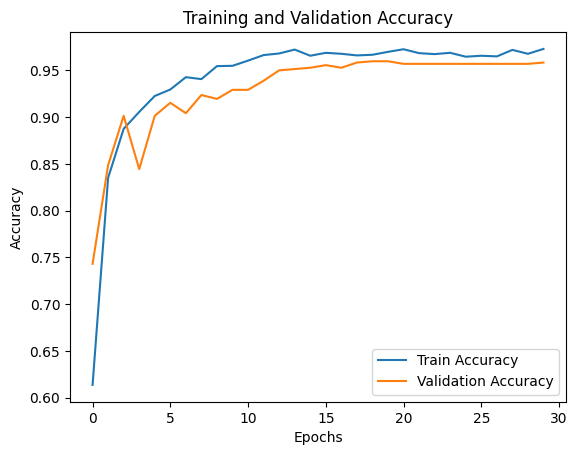

In [17]:
# Plot training history

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

try:
    plt.savefig(os.path.join(fdir,"fine_tuned_train_val_accuracy.jpg"))
except:
    print("Some error occurred while trying to save the Training and Validation Accuracy image!")

plt.show()

In [18]:
# Classification report and confusion matrix

y_pred = refined_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_to_index.keys())))

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step

Classification Report:
              precision    recall  f1-score   support

   flowering       1.00      1.00      1.00       204
         raw       0.95      0.96      0.96       170
        ripe       0.95      0.95      0.95       165
   semi_ripe       0.93      0.91      0.92       181

    accuracy                           0.96       720
   macro avg       0.96      0.96      0.96       720
weighted avg       0.96      0.96      0.96       720



In [19]:
# Precision, Recall and F1 scores

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.96
Recall: 0.96
F1 Score: 0.96


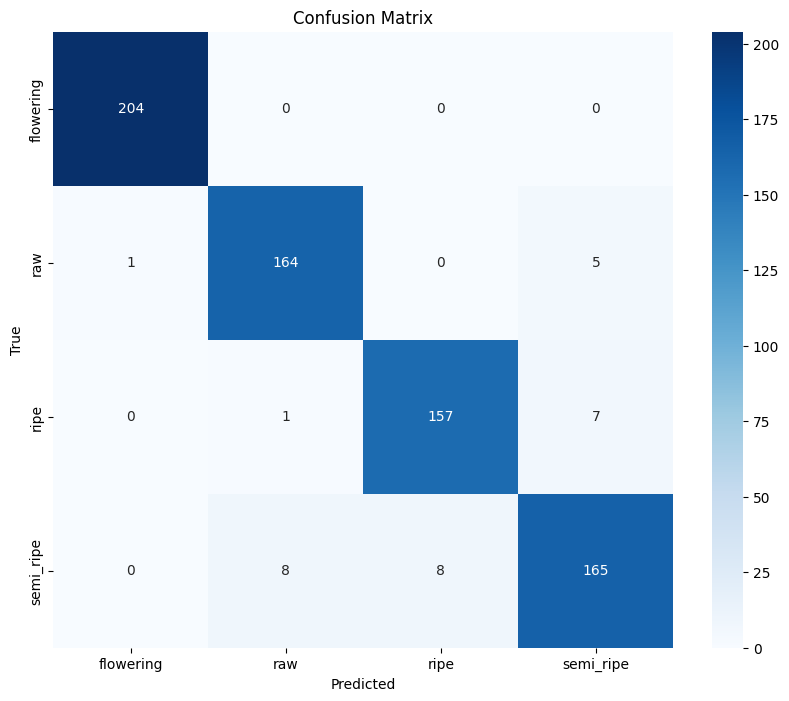

In [20]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(),
            yticklabels=label_to_index.keys())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

try:
    plt.savefig(os.path.join(fdir, "fine_tuned_confusion-matrix.jpg"))
except:
    print("Some error occurred while trying to save the Confusion Matrix plot image!")

plt.show()

In [21]:
# Test-Time Augmentation (TTA) for Inference

def tta_predict(model, img, augmentations=5):
    predictions = []
    for _ in range(augmentations):
        aug_img = datagen.random_transform(img)
        aug_img = np.expand_dims(aug_img, axis=0)
        predictions.append(model.predict(aug_img))
    return np.mean(predictions, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


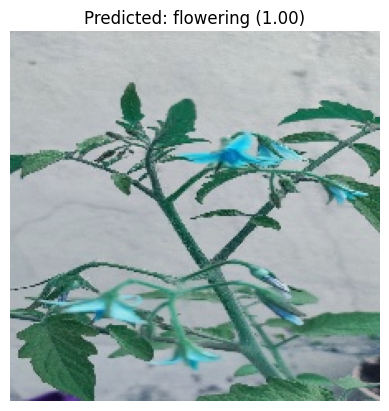

Predicted Label: flowering with confidence of 1.00


In [22]:
# Predict with TTA

test_img_path = "/kaggle/input/tomato-plant-dataset/Data/Flowering/flowering_280.jpg"

test_img = preprocess_image(test_img_path, img_size)
tta_prediction = tta_predict(refined_model, test_img)
predicted_label = index_to_label[np.argmax(tta_prediction)]
confidence = tta_prediction[0][np.argmax(tta_prediction)]

# display image
plt.imshow(test_img)
plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
plt.axis('off')
plt.show()

print(f"Predicted Label: {predicted_label} with confidence of {confidence:.2f}")